#paper2017---Original
- We're going to be training this on the simpsons character dataset

In [6]:
from tensorflow import keras
# import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.layers.advanced_activations import ELU
from sklearn.utils import class_weight
# from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels

# from vis.utils import utils
# from keras import activations

In [19]:
#### from __future__ import print_function


num_classes = 4
img_rows, img_cols = 224,224
batch_size =32
train_data_dir = "/home/kashraf/Research_2021/theta/train/"
validation_data_dir ="/home/kashraf/Research_2021/theta/test/"

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator()
#rescale=1./255)
validation_datagen = ImageDataGenerator()
 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
nb_train_samples = 26800
nb_validation_samples = 11008


Found 26800 images belonging to 4 classes.
Found 11008 images belonging to 4 classes.


In [ ]:
# class_weights = class_weight.compute_class_weight(
#                'balanced',
#                 np.unique(train_generator.classes), 
#                 train_generator.classes)
# print(class_weights)

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes,name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = ''
        else:
            title = ''
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.savefig(name, dpi = 1200)
    return ax

## Let's create our LittleVGG Model

In [21]:
model = Sequential()

# First CONV-ReLU Layer
model.add(Conv2D(32, (7, 7), padding = 'same', input_shape = (img_rows, img_cols,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second CONV-ReLU Layer
model.add(Conv2D(64, (5, 5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.4))


# Final Dense Layer
model.add(Dense(num_classes,activation='softmax',name='mbm'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      4736      
_________________________________________________________________
batch_normalization_12 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_14 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 64)      51264     
_________________________________________________________________
batch_normalization_13 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_15 (Activation)   (None, 112, 112, 64)     

In [ ]:
%matplotlib inline
plot_model(model, to_file='LittleVGG.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('LittleVGG.png')
plt.figure(figsize=(100,70))
plt.show()

### Training our LittleVGG Model!

In [22]:
             
checkpoint = ModelCheckpoint("/home/kashraf/Research_2021/saved_models/cnn_theta_jun28-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.000001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy'])


epochs = 100

history= model.fit(   
    
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/100
837/837 [==============================] - 1252s 1s/step - loss: 6.0336 - accuracy: 0.2778 - val_loss: 4.9809 - val_accuracy: 0.2687

Epoch 00001: val_loss improved from inf to 4.98089, saving model to /home/kashraf/Research_2021/saved_models/cnn_theta_jun28-v1.h5
Epoch 2/100
837/837 [==============================] - 1252s 1s/step - loss: 3.9952 - accuracy: 0.3407 - val_loss: 3.2412 - val_accuracy: 0.3242

Epoch 00002: val_loss improved from 4.98089 to 3.24116, saving model to /home/kashraf/Research_2021/saved_models/cnn_theta_jun28-v1.h5
Epoch 3/100
837/837 [==============================] - 1251s 1s/step - loss: 2.5375 - accuracy: 0.4316 - val_loss: 2.2263 - val_accuracy: 0.3873

Epoch 00003: val_loss improved from 3.24116 to 2.22632, saving model to /home/kashraf/Research_2021/saved_models/cnn_theta_jun28-v1.h5
Epoch 4/100
837/837 [==============================] - 1251s 1s/step - loss: 1.7458 - accuracy: 0.5294 - val_loss: 1.5376 - val_accuracy: 0.5420

Epoch 00004: va

837/837 [==============================] - 1252s 1s/step - loss: 0.2617 - accuracy: 0.9910 - val_loss: 0.7528 - val_accuracy: 0.8593

Epoch 00035: val_loss did not improve from 0.73475
Epoch 36/100
837/837 [==============================] - 1252s 1s/step - loss: 0.2615 - accuracy: 0.9907 - val_loss: 0.7528 - val_accuracy: 0.8588

Epoch 00036: val_loss did not improve from 0.73475
Epoch 37/100
837/837 [==============================] - 1251s 1s/step - loss: 0.2608 - accuracy: 0.9906 - val_loss: 0.7515 - val_accuracy: 0.8590

Epoch 00037: val_loss did not improve from 0.73475

Epoch 00037: ReduceLROnPlateau reducing learning rate to 2.55999976772614e-10.
Epoch 38/100
837/837 [==============================] - 1252s 1s/step - loss: 0.2618 - accuracy: 0.9904 - val_loss: 0.7530 - val_accuracy: 0.8596

Epoch 00038: val_loss did not improve from 0.73475
Epoch 39/100
837/837 [==============================] - 1252s 1s/step - loss: 0.2622 - accuracy: 0.9901 - val_loss: 0.7528 - val_accuracy: 0.


Epoch 00071: val_loss did not improve from 0.73475
Epoch 72/100
837/837 [==============================] - 1242s 1s/step - loss: 0.2631 - accuracy: 0.9904 - val_loss: 0.7526 - val_accuracy: 0.8592

Epoch 00072: val_loss did not improve from 0.73475
Epoch 73/100
837/837 [==============================] - 1242s 1s/step - loss: 0.2615 - accuracy: 0.9907 - val_loss: 0.7520 - val_accuracy: 0.8590

Epoch 00073: val_loss did not improve from 0.73475

Epoch 00073: ReduceLROnPlateau reducing learning rate to 1.0485759998112131e-18.
Epoch 74/100
837/837 [==============================] - 1243s 1s/step - loss: 0.2615 - accuracy: 0.9915 - val_loss: 0.7523 - val_accuracy: 0.8591

Epoch 00074: val_loss did not improve from 0.73475
Epoch 75/100
837/837 [==============================] - 1242s 1s/step - loss: 0.2628 - accuracy: 0.9898 - val_loss: 0.7524 - val_accuracy: 0.8592

Epoch 00075: val_loss did not improve from 0.73475
Epoch 76/100
837/837 [==============================] - 1242s 1s/step - lo

In [12]:
model.save("/home/kashraf/Research_2021/saved_models/cnn_theta_jun28-v1.h5")


## Performance Analysis

Found 11008 images belonging to 4 classes.


/home/kashraf/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[2431   47  232   42]
 [  43 2491  171   47]
 [ 231  193 2093  235]
 [  32   47  229 2444]]
Classification Report
              precision    recall  f1-score   support

         cl2       0.89      0.88      0.89      2752
         cl4       0.90      0.91      0.90      2752
         cl6       0.77      0.76      0.76      2752
         cl8       0.88      0.89      0.89      2752

    accuracy                           0.86     11008
   macro avg       0.86      0.86      0.86     11008
weighted avg       0.86      0.86      0.86     11008

Confusion matrix, without normalization
[[2431   47  232   42]
 [  43 2491  171   47]
 [ 231  193 2093  235]
 [  32   47  229 2444]]
Normalized confusion matrix
[[0.88335756 0.01707849 0.08430233 0.01526163]
 [0.015625   0.90515988 0.06213663 0.01707849]
 [0.08393895 0.07013081 0.76053779 0.08539244]
 [0.01162791 0.01707849 0.08321221 0.8880814 ]]


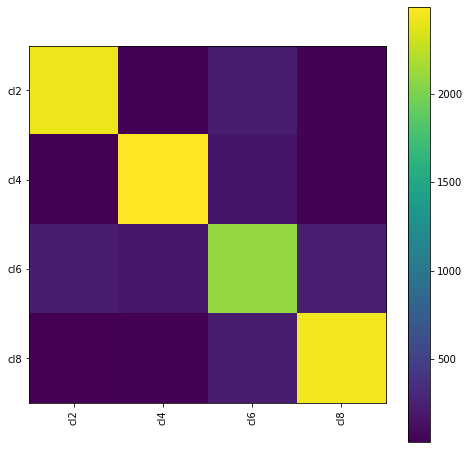

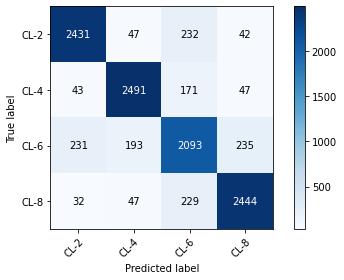

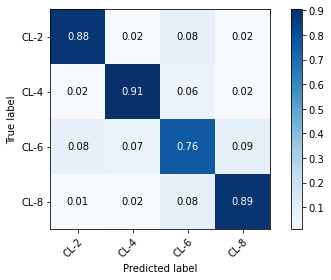

In [23]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
nb_train_samples = 29328
nb_validation_samples = 14672


#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

class_names=np.asarray(['CL-2','CL-4','CL-6','CL-8'])
# Plot non-normalized confusion matrix
plot_confusion_matrix(validation_generator.classes, y_pred, classes=class_names,title='',name='conf_matrix')
# Plot normalized confusion matrix
plot_confusion_matrix(validation_generator.classes, y_pred, classes=class_names, normalize=True,title='',name='conf_matrix_Nor')
plt.show()


### Plotting our Accuracy and Loss Charts

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


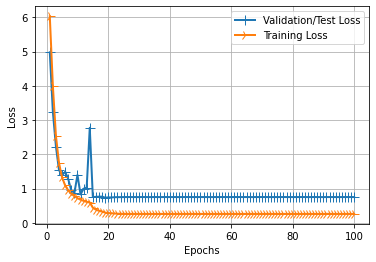

In [27]:

print(history.history.keys())
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('Loss_theta.png', dpi = 1200)
plt.show()

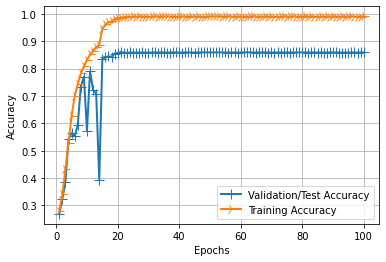

In [28]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('Accuracy_theta.png', dpi = 1200)
plt.show()

### Validation set

Found 6192 images belonging to 4 classes.
Confusion Matrix
[[1357   24  139   28]
 [  22 1401  106   19]
 [ 112  115 1182  139]
 [  21   25  116 1386]]
Classification Report
              precision    recall  f1-score   support

         cl2       0.90      0.88      0.89      1548
         cl4       0.90      0.91      0.90      1548
         cl6       0.77      0.76      0.76      1548
         cl8       0.88      0.90      0.89      1548

    accuracy                           0.86      6192
   macro avg       0.86      0.86      0.86      6192
weighted avg       0.86      0.86      0.86      6192

Confusion matrix, without normalization
[[1357   24  139   28]
 [  22 1401  106   19]
 [ 112  115 1182  139]
 [  21   25  116 1386]]
Normalized confusion matrix
[[0.87661499 0.01550388 0.08979328 0.01808786]
 [0.01421189 0.90503876 0.06847545 0.0122739 ]
 [0.07235142 0.07428941 0.76356589 0.08979328]
 [0.01356589 0.01614987 0.0749354  0.89534884]]


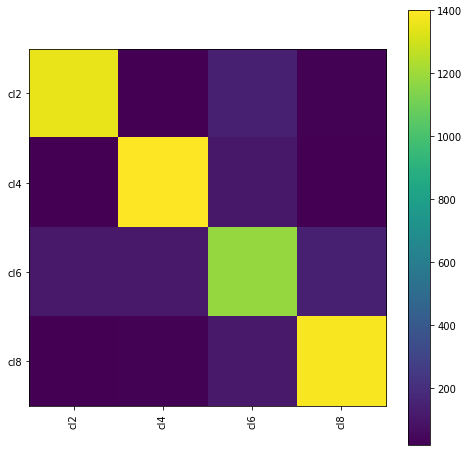

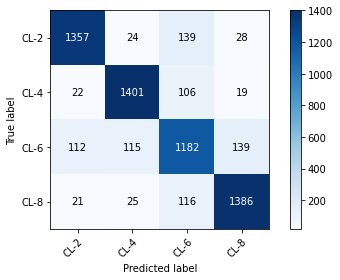

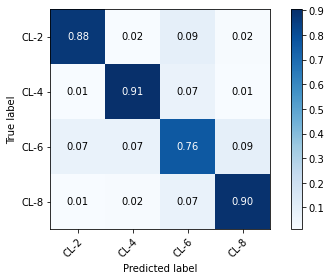

In [29]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
validation_data_dir="/home/kashraf/felix_hd/data_gen_may_2021/Audio_topomaps_June21/theta/validation/"
# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
nb_train_samples = 29328
nb_validation_samples = 14672


#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

class_names=np.asarray(['CL-2','CL-4','CL-6','CL-8'])
# Plot non-normalized confusion matrix
plot_confusion_matrix(validation_generator.classes, y_pred, classes=class_names,title='',name='conf_matrix')
# Plot normalized confusion matrix
plot_confusion_matrix(validation_generator.classes, y_pred, classes=class_names, normalize=True,title='',name='conf_matrix_Nor')
plt.show()


Found 6192 images belonging to 4 classes.


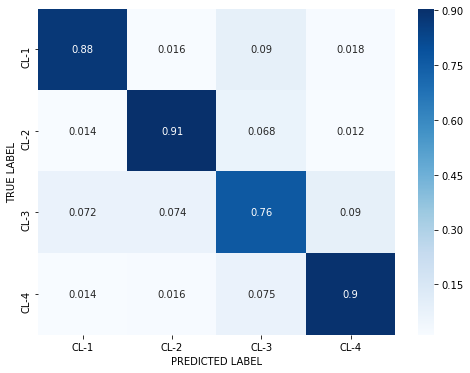

In [35]:
import seaborn as sr
validation_path=validation_data_dir ="/home/kashraf/felix_hd/data_gen_may_2021/Audio_topomaps_June21/theta/validation/"
validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
nb_train_samples = 29328
nb_validation_samples = 6192


#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
import pandas as pd
conf_mat=confusion_matrix(validation_generator.classes,y_pred,normalize='true')

conf_df=pd.DataFrame(conf_mat, index=["CL-1","CL-2","CL-3","CL-4"], columns=["CL-1","CL-2","CL-3","CL-4"])
# print("\nFace  accuracy =",accuracy)
# print("\n Face recognition report: \n",report)
fig=plt.figure(figsize=(8,6))
sr.heatmap(conf_df,annot=True,cmap="Blues")
# plt.title("Confusion matrix")
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.savefig("Conf_mat_theta_valid")

In [26]:
import pandas as pd
conf_mat=confusion_matrix(validation_generator.classes,y_pred,normalize='true')

conf_df=pd.DataFrame(conf_mat, index=["CL-1","CL-2","CL-3","CL-4"], columns=["CL-1","CL-2","CL-3","CL-4"])
# print("\nFace  accuracy =",accuracy)
# print("\n Face recognition report: \n",report)
fig=plt.figure(figsize=(8,6))
sr.heatmap(conf_df,annot=True,cmap="Blues")
# plt.title("Confusion matrix")
plt.savefig("Conf_mat_stack_valid")

In [ ]:
%matplotlib inline
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg

plot_model(model, to_file='LittleVGG.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('LittleVGG.png')
plt.figure(figsize=(100,70))
imgplot = plt.imshow(img) 

# Activation Maximization 

In [ ]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'mbm')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
#img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True)
for output_idx in np.arange(5):
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of OA level--{}'.format(output_idx))
    plt.imshow(img[..., 0])



## Visualizing Filter Patterns

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

input_image_path = './OAI_Classification_Images/224*224/validation/level_1/  9001695 1.jpg'

# Show our input Image for Feature visualization
img1 = image.load_img(input_image_path)
plt.imshow(img1);
img_size = (224, 224)
# load imamge into a 4D Tensor, convert it to a numpy array and expand to 4 dim
img1 = image.load_img(input_image_path, target_size = img_size)
image_tensor = image.img_to_array(img1)
#print(image_tensor.shape)
image_tensor = image_tensor/255
image_tensor = np.expand_dims(image_tensor, axis=0)
#print(img.shape)

In [ ]:
from keras import models

# Extracts the top 8 layers
layer_outputs = [layer.output for layer in model.layers[:13]]

# Creates a model that returns these outputs given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(image_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

In [ ]:
for i in range(0,32):
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')

In [ ]:
layer_names = []
for layer in model.layers[:13]:
    layer_names.append(layer.name)
images_per_row = 16

# Get CONV layers only
conv_layer_names = []
for layer_name in layer_names:
    if 'conv2d' in layer_name:
        conv_layer_names.append(layer_name)

for layer_name, layer_activation in zip(conv_layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')